In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from fbprophet import Prophet

In [53]:
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
sales_df = pd.read_csv('train.csv')

In [5]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False


In [6]:
df = sales_df[(sales_df['Store']==1)&(sales_df['Dept']==1)][['Date', 'Weekly_Sales']]

In [7]:
df.head()

,Date,Weekly_Sales
0,2/5/2010,24924.50
1,2/12/2010,46039.49
2,2/19/2010,41595.55
3,2/26/2010,19403.54
4,3/5/2010,21827.90


In [8]:
df.tail()

,Date,Weekly_Sales
138,9/28/2012,18947.81
139,10/5/2012,21904.47
140,10/12/2012,22764.01
141,10/19/2012,24185.27
142,10/26/2012,27390.81


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null object
Weekly_Sales    143 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [10]:
df['Date'] = pd.DatetimeIndex(df['Date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null datetime64[ns]
Weekly_Sales    143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [12]:
df = df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

In [13]:
df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [14]:
orig_df = df.copy()

In [16]:
#orig_df

In [17]:
df['y'] = np.log(df['y'])

In [18]:
df.head()

,ds,y
0,2010-02-05,10.123607
1,2010-02-12,10.737255
2,2010-02-19,10.635748
3,2010-02-26,9.873211
4,2010-03-05,9.990944


In [19]:
# Visualize the data

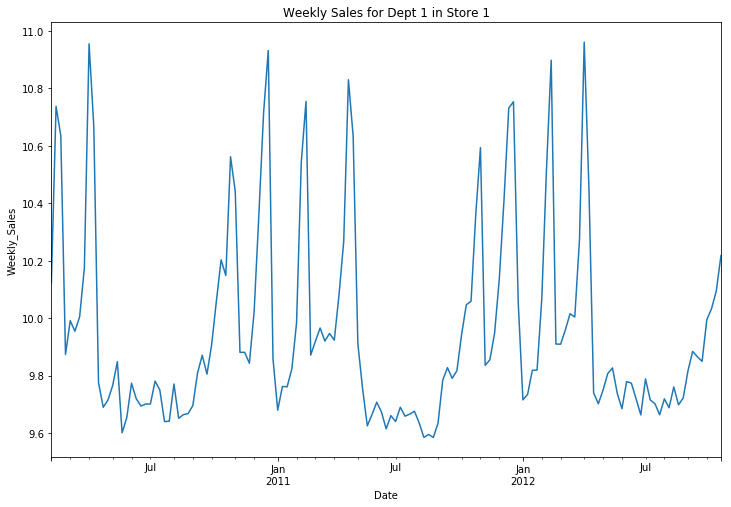

In [20]:
df.set_index('ds').y.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.title('Weekly Sales for Dept 1 in Store 1');

In [21]:
## Get the holiday info for Store 1, Dept 1
sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [22]:
holiday_dates = sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

In [23]:
holiday_dates

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [24]:
holiday_dates['Date'].values

array(['2/12/2010', '9/10/2010', '11/26/2010', '12/31/2010', '2/11/2011',
       '9/9/2011', '11/25/2011', '12/30/2011', '2/10/2012', '9/7/2012'], dtype=object)

In [25]:
holidays_df = pd.DataFrame({
    'holiday': 'national_holiday',
    'ds': pd.to_datetime(holiday_dates['Date'].values),
    'lower_window': 0,
    'upper_window': 0
})

In [26]:
holidays_df

,ds,holiday,lower_window,upper_window
0,2010-02-12,national_holiday,0,0
1,2010-09-10,national_holiday,0,0
2,2010-11-26,national_holiday,0,0
3,2010-12-31,national_holiday,0,0
4,2011-02-11,national_holiday,0,0
5,2011-09-09,national_holiday,0,0
6,2011-11-25,national_holiday,0,0
7,2011-12-30,national_holiday,0,0
8,2012-02-10,national_holiday,0,0
9,2012-09-07,national_holiday,0,0


In [27]:
## Using Prophet

In [28]:
model = Prophet(holidays=holidays_df)

In [29]:
model.fit(df);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
future = model.make_future_dataframe(periods=40, freq='W-FRI')

In [46]:
future.tail()

,ds
178,2013-07-05
179,2013-07-12
180,2013-07-19
181,2013-07-26
182,2013-08-02


In [48]:
## Perform Cross validation to measure forecast error

In [49]:
df_cv = cross_validation(model, horizon='120 days')
# horizon=120 days, initial=360 days, period=60 days
# horizon=17 weeks, initial=51 weeks, period=9 weeks
# Computes forecasts from historical cutoff points. 
# Beginning from initial, makes cutoffs with a spacing of period up to (end - horizon).

In [51]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-03-11,9.682085,9.479918,9.885774,9.965542,2011-03-06
1,2011-03-18,9.921219,9.732303,10.117298,9.920061,2011-03-06
2,2011-03-25,10.372654,10.190045,10.558548,9.946600,2011-03-06
3,2011-04-01,10.645884,10.456243,10.843992,9.923197,2011-03-06
4,2011-04-08,10.500596,10.295043,10.696542,10.080536,2011-03-06
5,2011-04-15,10.062019,9.860422,10.242681,10.266823,2011-03-06
6,2011-04-22,9.674790,9.477575,9.853427,10.829933,2011-03-06
7,2011-04-29,9.563888,9.375055,9.755027,10.633747,2011-03-06
8,2011-05-06,9.660824,9.459677,9.836109,9.910373,2011-03-06
9,2011-05-13,9.745209,9.568846,9.948169,9.754706,2011-03-06


In [54]:
mean_squared_error(df_cv.y, df_cv.yhat)

0.048252839403246386

In [55]:
mean_absolute_error(df_cv.y, df_cv.yhat)

0.14111917348691413

In [57]:
##The MSE and MAE are smaller, indicating minimal error

In [58]:
## Predict for future dates

In [59]:
forecast = model.predict(future)

In [60]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,holidays,holidays_lower,holidays_upper,national_holiday,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
178,2013-07-05,9.973205,9.972819,9.973585,9.483972,9.927073,0.0,0.0,0.0,0.0,...,-0.270424,-0.270424,-0.270424,-0.270424,-0.270424,-0.270424,-0.270424,-0.270424,-0.270424,9.702781
179,2013-07-12,9.973320,9.972916,9.973718,9.485078,9.965982,0.0,0.0,0.0,0.0,...,-0.248576,-0.248576,-0.248576,-0.248576,-0.248576,-0.248576,-0.248576,-0.248576,-0.248576,9.724743
180,2013-07-19,9.973435,9.973017,9.973854,9.503188,9.964031,0.0,0.0,0.0,0.0,...,-0.248630,-0.248630,-0.248630,-0.248630,-0.248630,-0.248630,-0.248630,-0.248630,-0.248630,9.724805
181,2013-07-26,9.973550,9.973115,9.973978,9.477477,9.925323,0.0,0.0,0.0,0.0,...,-0.278368,-0.278368,-0.278368,-0.278368,-0.278368,-0.278368,-0.278368,-0.278368,-0.278368,9.695182
182,2013-08-02,9.973665,9.973212,9.974112,9.444374,9.919204,0.0,0.0,0.0,0.0,...,-0.307767,-0.307767,-0.307767,-0.307767,-0.307767,-0.307767,-0.307767,-0.307767,-0.307767,9.665898


In [61]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
178,2013-07-05,9.702781,9.483972,9.927073
179,2013-07-12,9.724743,9.485078,9.965982
180,2013-07-19,9.724805,9.503188,9.964031
181,2013-07-26,9.695182,9.477477,9.925323
182,2013-08-02,9.665898,9.444374,9.919204


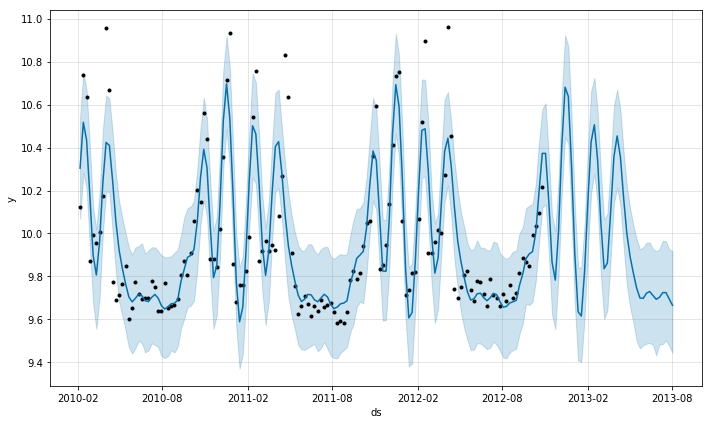

In [62]:
model.plot(forecast);

In [63]:
#Original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

In [64]:
# **** QUESTION - Why is the forecast error large here ?

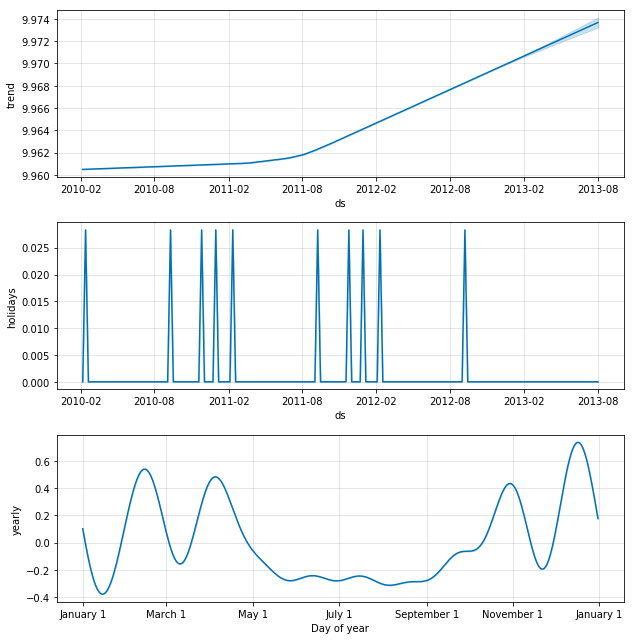

In [65]:
model.plot_components(forecast);

In [66]:
# Metrics

In [70]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,10.303971,10.068161,10.538628
1,2010-02-12,10.517674,10.282739,10.749598
2,2010-02-19,10.434750,10.209918,10.668011
3,2010-02-26,10.177764,9.942992,10.408125
4,2010-03-05,9.900382,9.676965,10.123189
5,2010-03-12,9.806893,9.555952,10.018731
6,2010-03-19,9.961710,9.700356,10.188897
7,2010-03-26,10.236474,9.999913,10.481456
8,2010-04-02,10.423800,10.194930,10.641796
9,2010-04-09,10.410195,10.191577,10.628171


In [72]:
df.head()

,ds,y
0,2010-02-05,10.123607
1,2010-02-12,10.737255
2,2010-02-19,10.635748
3,2010-02-26,9.873211
4,2010-03-05,9.990944


In [85]:
metrics_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [92]:
metrics_df.head()

,ds,yhat,y
0,2010-02-05,10.303971,10.123607
1,2010-02-12,10.517674,10.737255
2,2010-02-19,10.434750,10.635748
3,2010-02-26,10.177764,9.873211
4,2010-03-05,9.900382,9.990944


In [93]:
metrics_df.tail()

,ds,yhat,y
178,2013-07-05,9.702781,NaN
179,2013-07-12,9.724743,NaN
180,2013-07-19,9.724805,NaN
181,2013-07-26,9.695182,NaN
182,2013-08-02,9.665898,NaN


In [95]:
metrics_df.dropna(inplace=True)

In [96]:
metrics_df.tail()

,ds,yhat,y
138,2012-09-28,9.905179,9.849444
139,2012-10-05,9.915454,9.994446
140,2012-10-12,10.003092,10.032936
141,2012-10-19,10.193211,10.093499
142,2012-10-26,10.372800,10.217963


In [97]:
r2_score(metrics_df.y, metrics_df.yhat)

0.71798480682652688

In [98]:
mean_squared_error(metrics_df.y, metrics_df.yhat)

0.03299986855916183

In [99]:
mean_absolute_error(metrics_df.y, metrics_df.yhat)

0.12080662533903852